In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from keras.models import Sequential
from keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
import keras
from keras.optimizers import RMSprop
import matplotlib as mpl

: 

In [2]:
EPOCHS = 20
BATCH_SIZE = 16
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
dict_train = np.load('noAnno_train_14_nucleotide_array_with_cluster0.npz')
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('noAnno_train_14_nucleotide_labels_with_cluster0.npy')
y_train = y_flt_train.astype(int)
print(y_train)


dict_test = np.load('noAnno_test_14_nucleotide_array_with_cluster0.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('noAnno_test_14_nucleotide_labels_with_cluster0.npy')
y_test = y_flt_test.astype(int)
print(y_test)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

[0 0 0 ... 0 0 0]
[1 0 0 ... 1 0 0]
Training features shape: (52739, 14, 4)
Test features shape: (26370, 14, 4)
Training labels shape: (52739,)
Test labels shape: (26370,)


In [3]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2024-01-09 01:24:29.849709: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-09 01:24:29.849732: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-09 01:24:29.849735: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-09 01:24:29.850142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-09 01:24:29.850327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
neg, pos = np.bincount(y_train)+np.bincount(y_test)
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)

Examples:
    Total: 79109
    Positive: 5578 (7.05% of total)

Training labels shape: (52739,)
Test labels shape: (26370,)
Training features shape: (52739, 14, 4)
Test features shape: (26370, 14, 4)


In [5]:
def make_model1(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        # The input shape is 14x4
        # This is the first convolution
        Conv1D(16, 3, strides=1, activation='relu', padding='same',
               input_shape=(14, 4),
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Conv1D(32, 3, strides=1, activation='relu', padding='same',
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Flatten(),
        #  neuron hidden layer
        Dense(224, activation='relu', bias_initializer=output_bias),  # 14/2(maxpooling)=7, 32*7 = 224
        Dropout(0.2),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
        Dense(1, activation='sigmoid')  # Sigmoid for binary question.
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # optimizer=RMSprop(lr=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [6]:
def make_model2(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        # The input shape is 14x4
        # This is the first convolution
        Conv1D(64, 3, strides=1, activation='relu', padding='same',
               input_shape=(14, 4),
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Conv1D(32, 3, strides=1, activation='relu', padding='same',
               kernel_initializer='he_normal',
               bias_initializer='zeros'),
        MaxPooling1D(pool_size=2, strides=2),
        Dropout(0.2),
        Flatten(),
        #  neuron hidden layer
        Dense(224, activation='relu', bias_initializer=output_bias),  # 14/2(maxpooling)=7, 32*7 = 224
        Dropout(0.2),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
        Dense(1, activation='sigmoid')  # Sigmoid for binary question.
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # optimizer=RMSprop(lr=0.001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [7]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  # plt.semilogy(history.epoch, history.history['val_loss'],
  #              color=colors[n], label='Val ' + label,
  #              linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [8]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-GNRA Detected (True Negatives): ', cm[0][0])
  print('Non-GNRA Incorrectly Detected (False Positives): ', cm[0][1])
  print('GNRA Missed (False Negatives): ', cm[1][0])
  print('GNRA Detected (True Positives): ', cm[1][1])
  print('Total GNRA: ', np.sum(cm[1]))

In [9]:
def plot_metrics(history1, history2):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history1.epoch, history1.history[metric], color=colors[0], label='Conf1_Train')
    plt.plot(history1.epoch, history1.history['val_' + metric],
             color=colors[0], linestyle="--", label='Conf1_Test')
    plt.plot(history2.epoch, history2.history[metric], color=colors[1], label='Conf2_Train')
    plt.plot(history2.epoch, history2.history['val_' + metric],
             color=colors[1], linestyle="--", label='Conf2_Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [10]:
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)

  plt.rcParams['font.size'] = '16'
  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate = fp/(fp+tn)')
  plt.ylabel('True positives rate = tp/(tp+fn)')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [11]:
def plot_prc(name, labels, predictions, **kwargs):  #precision = tp / (tp + fp), recall = tp / (tp + fn)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.rcParams['font.size'] = '9'
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall = TP / (TP + FP)')
    plt.ylabel('Precision = TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [12]:
# retrain with class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 7.09


In [14]:
weighted_model1 = make_model1()
#weighted_model.load_weights(initial_weights)

weighted_history1 = weighted_model1.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 0.54, 1: 7.09})

Epoch 1/20


2024-01-09 01:25:04.607159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3297/3297 [==============================] - ETA: 0s - loss: 0.2128 - tp: 3687.0000 - fp: 5345.0000 - tn: 47347.0000 - fn: 328.0000 - accuracy: 0.9000 - precision: 0.4082 - recall: 0.9183 - auc: 0.9674 - prc: 0.7598

2024-01-09 01:25:49.257569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3297/3297 [==============================] - 56s 17ms/step - loss: 0.2128 - tp: 3687.0000 - fp: 5345.0000 - tn: 47347.0000 - fn: 328.0000 - accuracy: 0.9000 - precision: 0.4082 - recall: 0.9183 - auc: 0.9674 - prc: 0.7598 - val_loss: 0.0875 - val_tp: 1754.0000 - val_fp: 730.0000 - val_tn: 23784.0000 - val_fn: 102.0000 - val_accuracy: 0.9684 - val_precision: 0.7061 - val_recall: 0.9450 - val_auc: 0.9910 - val_prc: 0.9172
Epoch 2/20
3297/3297 [==============================] - 55s 17ms/step - loss: 0.1328 - tp: 3571.0000 - fp: 2451.0000 - tn: 46566.0000 - fn: 151.0000 - accuracy: 0.9507 - precision: 0.5930 - recall: 0.9594 - auc: 0.9879 - prc: 0.8688 - val_loss: 0.1361 - val_tp: 1819.0000 - val_fp: 1207.0000 - val_tn: 23307.0000 - val_fn: 37.0000 - val_accuracy: 0.9528 - val_precision: 0.6011 - val_recall: 0.9801 - val_auc: 0.9930 - val_prc: 0.9225
Epoch 3/20
3297/3297 [==============================] - 56s 17ms/step - loss: 0.1219 - tp: 3598.0000 - fp: 2104.0000 - tn: 46913.0000 - fn: 1

In [15]:
weighted_model2 = make_model2()
#weighted_model.load_weights(initial_weights)

weighted_history2 = weighted_model2.fit(
    x_train,
    y_train, 
    validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 0.54, 1: 7.09})

Epoch 1/20


2024-01-09 01:44:14.457427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3297/3297 [==============================] - ETA: 0s - loss: 0.1826 - tp: 4898.0000 - fp: 3878.0000 - tn: 69653.0000 - fn: 680.0000 - accuracy: 0.9424 - precision: 0.5581 - recall: 0.8781 - auc: 0.9367 - prc: 0.7766

2024-01-09 01:45:01.307135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3297/3297 [==============================] - 59s 18ms/step - loss: 0.1826 - tp: 4898.0000 - fp: 3878.0000 - tn: 69653.0000 - fn: 680.0000 - accuracy: 0.9424 - precision: 0.5581 - recall: 0.8781 - auc: 0.9367 - prc: 0.7766 - val_loss: 0.0990 - val_tp: 1820.0000 - val_fp: 944.0000 - val_tn: 23570.0000 - val_fn: 36.0000 - val_accuracy: 0.9628 - val_precision: 0.6585 - val_recall: 0.9806 - val_auc: 0.9937 - val_prc: 0.9382
Epoch 2/20
3297/3297 [==============================] - 57s 17ms/step - loss: 0.1007 - tp: 3619.0000 - fp: 1798.0000 - tn: 47219.0000 - fn: 103.0000 - accuracy: 0.9640 - precision: 0.6681 - recall: 0.9723 - auc: 0.9918 - prc: 0.9021 - val_loss: 0.1272 - val_tp: 1843.0000 - val_fp: 1155.0000 - val_tn: 23359.0000 - val_fn: 13.0000 - val_accuracy: 0.9557 - val_precision: 0.6147 - val_recall: 0.9930 - val_auc: 0.9949 - val_prc: 0.9403
Epoch 3/20
3297/3297 [==============================] - 58s 18ms/step - loss: 0.0839 - tp: 3640.0000 - fp: 1461.0000 - tn: 47556.0000 - fn: 82

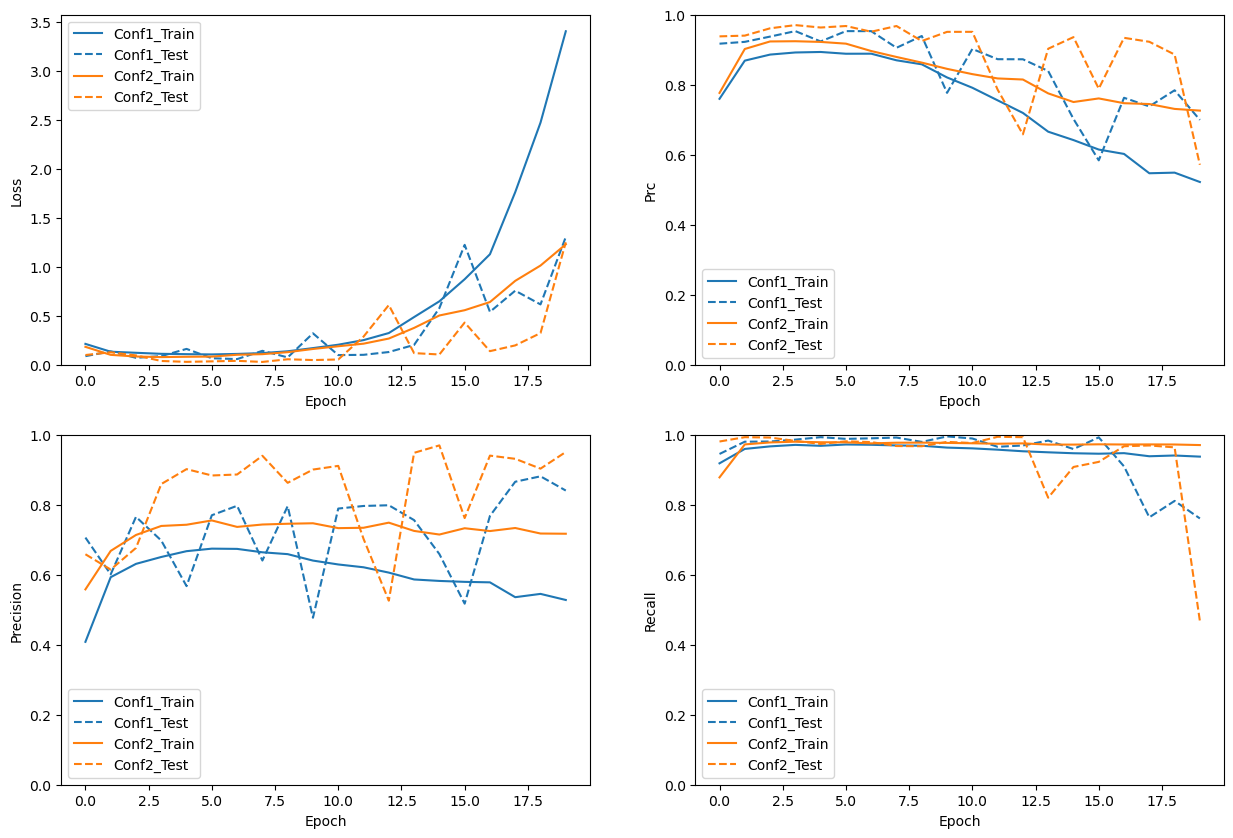

In [16]:
plot_metrics(weighted_history1, weighted_history2)

In [17]:
train_predictions_weighted1 = weighted_model1.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted1 = weighted_model1.predict(x_test, batch_size=BATCH_SIZE)

  77/3297 [..............................] - ETA: 6s

2024-01-09 02:06:58.845611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1649/1649 [==============================] - 3s 2ms/step


In [18]:
train_predictions_weighted2 = weighted_model2.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted2 = weighted_model2.predict(x_test, batch_size=BATCH_SIZE)

  78/3297 [..............................] - ETA: 6s

2024-01-09 02:07:10.614593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1649/1649 [==============================] - 3s 2ms/step


loss :  1.305061936378479
tp :  1412.0
fp :  268.0
tn :  24246.0
fn :  444.0
accuracy :  0.9729995727539062
precision :  0.8404762148857117
recall :  0.7607758641242981
auc :  0.8803573846817017
prc :  0.699546754360199

Non-GNRA Detected (True Negatives):  24246
Non-GNRA Incorrectly Detected (False Positives):  268
GNRA Missed (False Negatives):  444
GNRA Detected (True Positives):  1412
Total GNRA:  1856


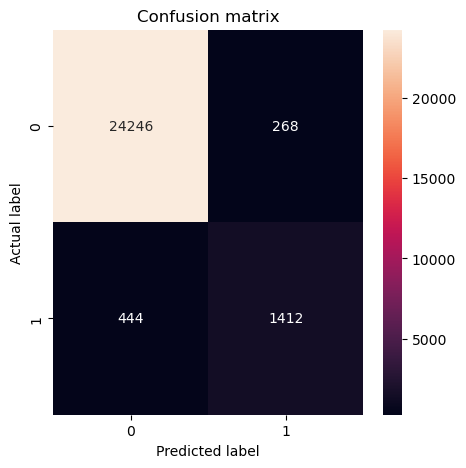

In [19]:
# Results of test data set. 
weighted_results1 = weighted_model1.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model1.metrics_names, weighted_results1):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted1)

loss :  1.305061936378479
tp :  1412.0
fp :  268.0
tn :  24246.0
fn :  444.0
accuracy :  0.9729995727539062
precision :  0.8404762148857117
recall :  0.7607758641242981
auc :  0.8803573846817017
prc :  0.699546754360199

Non-GNRA Detected (True Negatives):  24469
Non-GNRA Incorrectly Detected (False Positives):  45
GNRA Missed (False Negatives):  988
GNRA Detected (True Positives):  868
Total GNRA:  1856


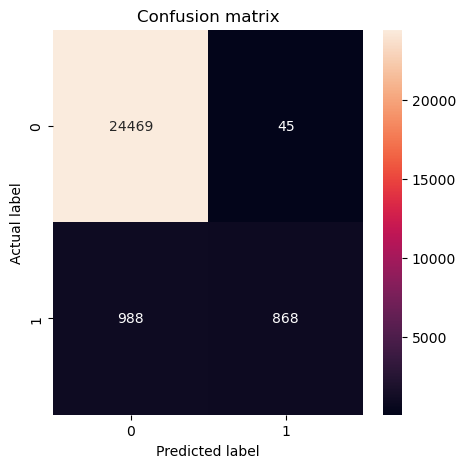

In [20]:
# Results of test data set. 
weighted_results2 = weighted_model2.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model2.metrics_names, weighted_results1):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted2)

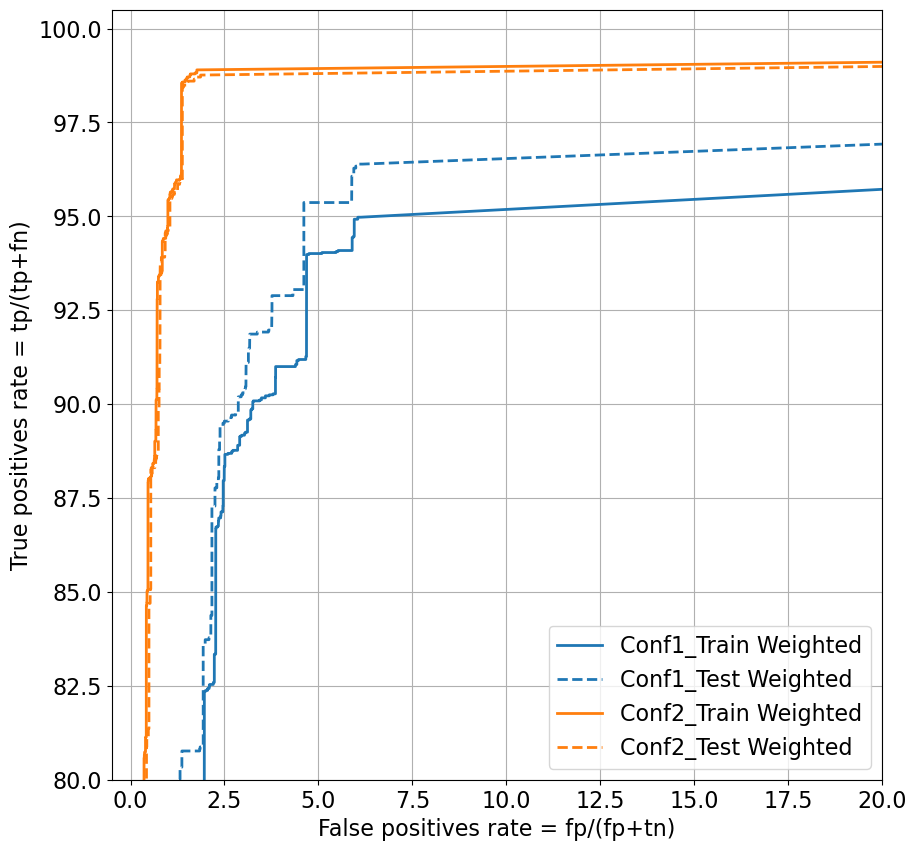

In [21]:
plot_roc("Conf1_Train Weighted", y_train, train_predictions_weighted1, color=colors[0])
plot_roc("Conf1_Test Weighted", y_test, test_predictions_weighted1, color=colors[0], linestyle='--')
plot_roc("Conf2_Train Weighted", y_train, train_predictions_weighted2, color=colors[1])
plot_roc("Conf2_Test Weighted", y_test, test_predictions_weighted2, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

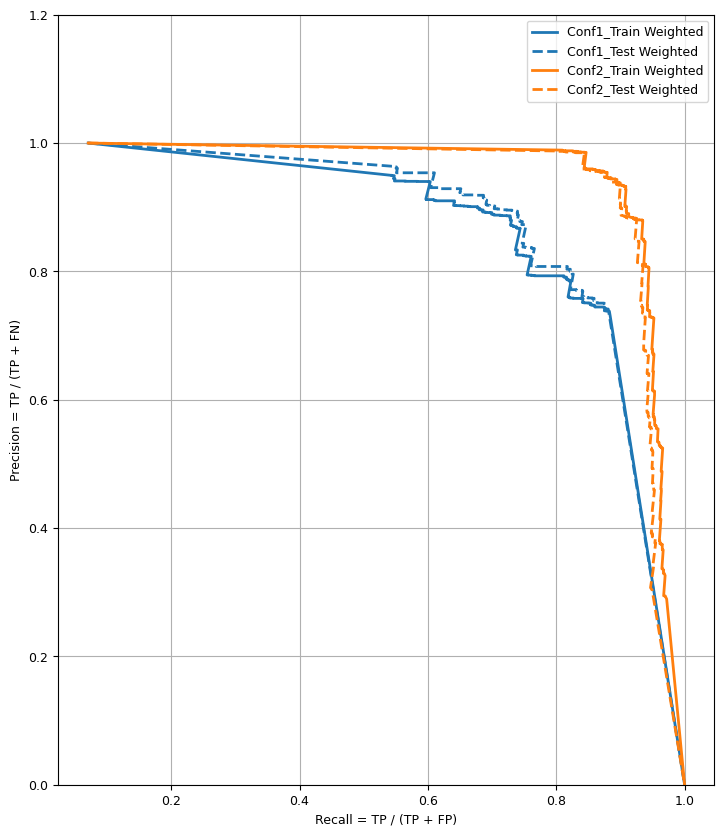

In [22]:
plot_prc("Conf1_Train Weighted", y_train, train_predictions_weighted1, color=colors[0])
plot_prc("Conf1_Test Weighted", y_test, test_predictions_weighted1, color=colors[0], linestyle='--')
plot_prc("Conf2_Train Weighted", y_train, train_predictions_weighted2, color=colors[1])
plot_prc("Conf2_Test Weighted", y_test, test_predictions_weighted2, color=colors[1], linestyle='--')
# plt.xlim([0, 1.2])
plt.ylim([0, 1.2])

plt.legend(loc='upper right');